# The Goal of this Project
In this project, your goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are available in [the project repository](https://github.com/udacity/CarND-Advanced-Lane-Lines).

## my workflow
1. explore data, calibrate image: undistort and warp into top-down view
2. use sobel and color space technique to stand out the lanelines
3. get laneline position and curvation
4. build a pipeline and produce a video

# 1 explore data, calibrate image: undistort and warp into top-down view
1. show exmaple image
2. calibrate camera
3. warp image into topdown view
4. use mask to narrow down area of interest

In [1]:
# create a folder to store extracted images
import os
folder = 'project_video'  
#folder = "harder_challenge_video"
#os.mkdir(folder)

In [2]:
# use opencv to do the job
import cv2
print(cv2.__version__)  # my version is 3.1.0
vidcap = cv2.VideoCapture('project_video.mp4')  # 1260 images = 50 s * 25 fps
# vidcap = cv2.VideoCapture('harder_challenge_video.mp4') # 1199
count = 0
while True:
    success,image = vidcap.read()
    if not success:
        break
    cv2.imwrite(os.path.join(folder,"{:d}.jpg".format(count)), image)     # save frame as JPEG file
    count += 1
print("{} images are extacted in {}.".format(count,folder))

3.1.0


KeyboardInterrupt: 

In [3]:
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import cv2
import glob

paths = glob.glob('project_video/*.jpg')
n = len(paths) # 1260

project_video/1170.jpg
(720, 1280, 3)


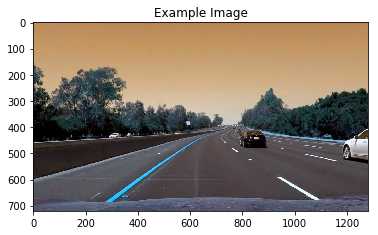

In [4]:
index = np.random.randint(n)
image = cv2.imread(paths[index])
print(paths[index])
print(image.shape)  # get shape (64,64,3)

fig = plt.figure()
plt.imshow(image)
plt.title('Example Image')
plt.show()

## 1.2 calibrate camera

In [5]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
nx, ny = 9, 6
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2) # last element in each cell is left 0

objpoints = [] # 3d points in real world space, as reference.
imgpoints = [] # 2d points in image plane, distorb as much as you can 

cal_paths = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for path in cal_paths:
    cal_image = cv2.imread(path)
    ret, corners = cv2.findChessboardCorners(image = cal_image[:,:,0], patternSize = (nx,ny))
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
    else:
        print(path)

camera_cal/calibration1.jpg
camera_cal/calibration5.jpg


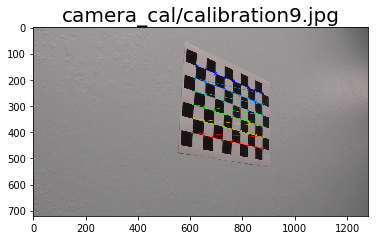

In [6]:
cv2.drawChessboardCorners(cal_image, (nx,ny), corners, ret)
plt.imshow(cal_image)
plt.title(path, fontsize=20)
plt.show()

In [7]:
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, cal_image.shape[0:2],None,None)
from sklearn.externals import joblib
joblib.dump((mtx,dist), "9x6dist.p")  # for later use

['9x6dist.p']

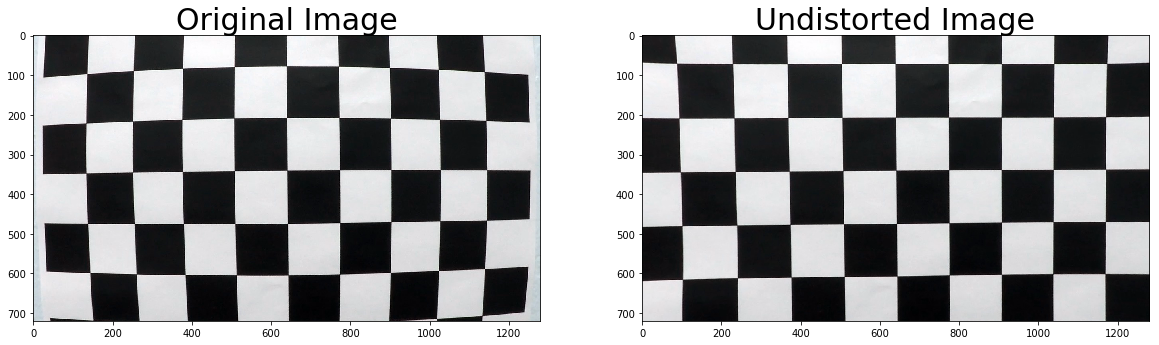

In [39]:
index = np.random.randint(len(cal_paths))
vip = 'camera_cal/calibration1.jpg'
# cal_image = cv2.imread(cal_paths[index])
cal_image = cv2.imread(vip)

dst_image = cv2.undistort(cal_image, mtx, dist, None, mtx)

# Visualize undistortion
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(cal_image)
plt.title('Original Image', fontsize=30)

plt.subplot(1,2,2)
plt.imshow(dst_image)
plt.title('Undistorted Image', fontsize=30)
plt.show()

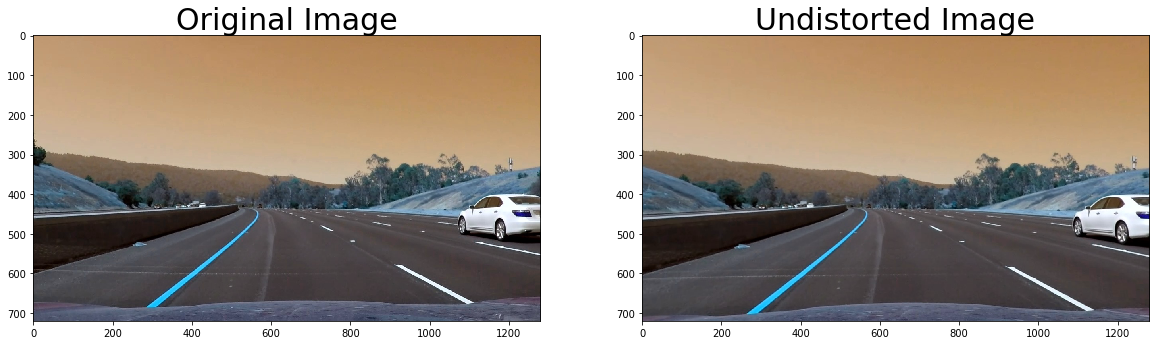

In [15]:
index = np.random.randint(len(paths))
cal_image = cv2.imread(paths[index])
dst_image = cv2.undistort(cal_image, mtx, dist, None, mtx)

# Visualize undistortion
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(cal_image)
plt.title('Original Image', fontsize=30)

plt.subplot(1,2,2)
plt.imshow(dst_image)
plt.title('Undistorted Image', fontsize=30)
plt.show()

## 1.3 warp image into topdown view
The difficulty here is the "ground truth" value for the destination points. We should have the same camera shoot on a pair of straight lane lines as our reference points. 

In [9]:
from skimage.viewer import ImageViewer
from matplotlib.image import imread
image = imread("solidWhiteRight.jpg") # shape (540, 960, 3)
viewer = ImageViewer(image)
viewer.show() # to read pixel postion

[]

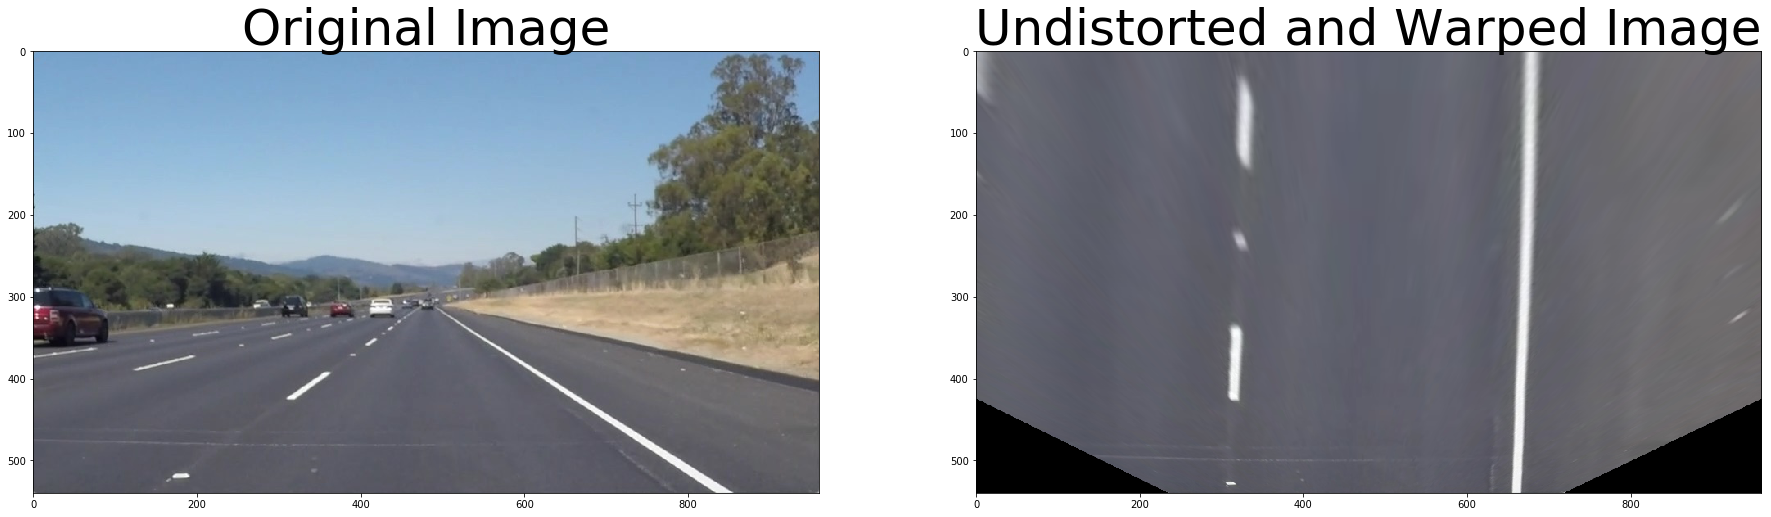

In [13]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
src = np.float32([[159,539],[315,424],[660,424],[844,539]])
dst = np.float32([[314,539],[315,424],[660,424],[660,539]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
top_down = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]))

f = plt.figure(figsize=(24, 9))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image', fontsize=50)

plt.subplot(122)
plt.imshow(top_down)
plt.title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

This seems good. But the image size is different from the video and cammera_cal. So it is likely taken from different camera and different angle. Then this tranform matrix is not readily applicable to this project.

After carefully exam the project video, I found the car is driving in straight lanelines around 311th frame.

In [64]:
import matplotlib.image as mpimg
image = mpimg.imread("project_video/311.jpg") # shape (540, 960, 3)


In [ ]:
from skimage.viewer import ImageViewer
viewer = ImageViewer(image)
viewer.show() # to read pixel postion

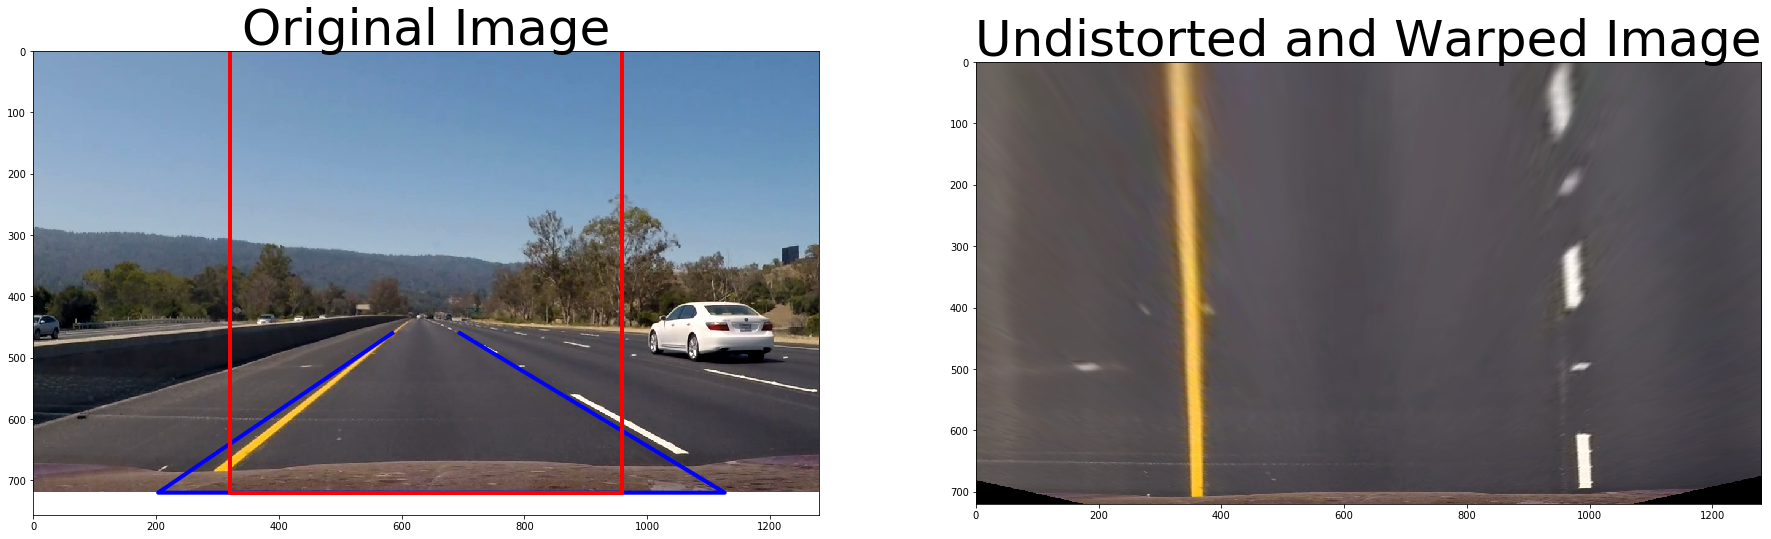

In [65]:
src = np.float32([[360,640],[480,550],[860,550],[1040,640]])
dst = np.float32([[480,640],[480,550],[860,550],[860,640]])

ymax,xmax = image.shape[0:2]
src = np.float32([[xmax/2-55, ymax/2+100],[xmax/6-10, ymax],[xmax*5/6+60,ymax],[xmax/2+55, ymax/2+100]])
dst = np.float32([[xmax/4, 0],            [xmax/4, ymax],   [xmax*3/4, ymax],  [xmax*3/4, 0]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
top_down = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]))

f = plt.figure(figsize=(24, 9))
plt.subplot(121)
plt.imshow(image)
plt.plot(src[:,0],src[:,1],color='blue',linewidth = 4)
plt.plot(dst[:,0],dst[:,1],color='red',linewidth = 4)
plt.title('Original Image', fontsize=50)

plt.subplot(122)
plt.imshow(top_down)

plt.title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

In [103]:
src,dst

(array([[  585.        ,   460.        ],
        [  203.33332825,   720.        ],
        [ 1126.66662598,   720.        ],
        [  695.        ,   460.        ]], dtype=float32),
 array([[ 320.,    0.],
        [ 320.,  720.],
        [ 960.,  720.],
        [ 960.,    0.]], dtype=float32))

In [62]:
from sklearn.externals import joblib
joblib.dump((M,Minv), "Ptransform.p") 

['Ptransform.p']

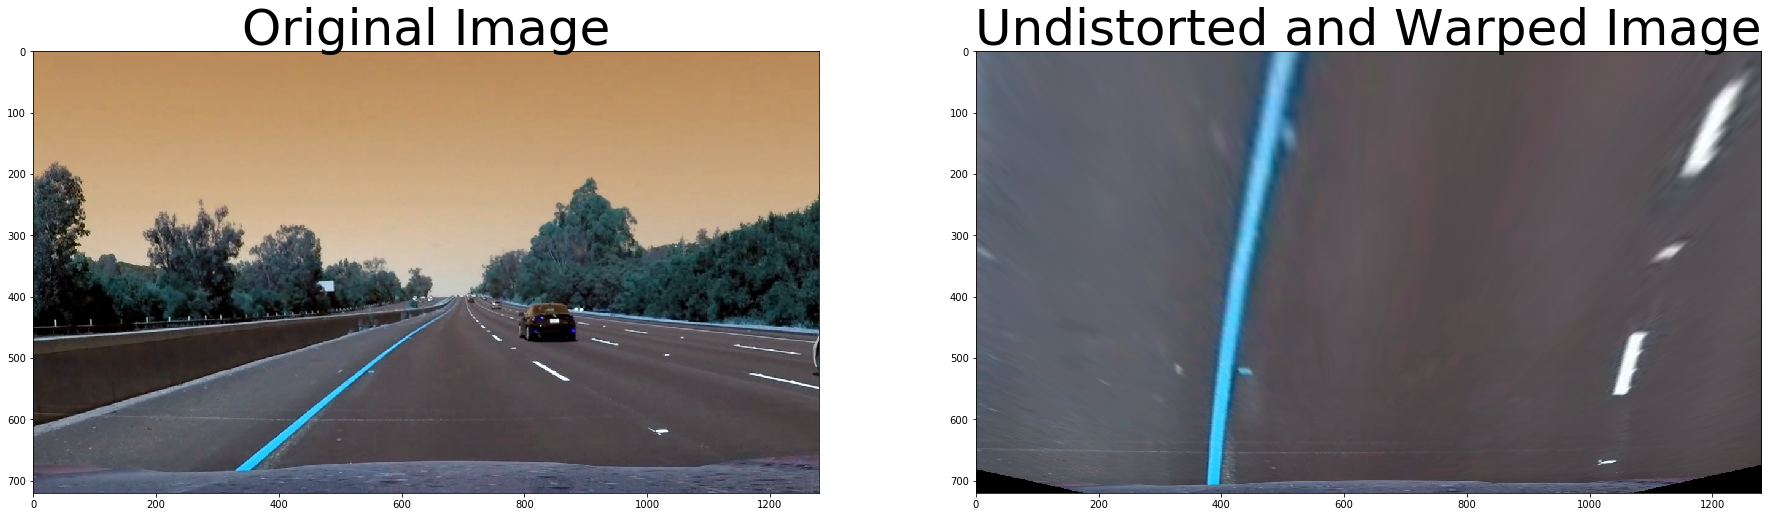

In [63]:
## try radom image
index = np.random.randint(len(paths))
image = cv2.imread(paths[index])
#image = imread("project_video/311.jpg")
top_down = cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]))

f = plt.figure(figsize=(24, 9))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image', fontsize=50)

plt.subplot(122)
plt.imshow(top_down)
plt.title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

## 1.4 use mask to narrow down area of interest

In [219]:
# use mask 
def process_image(image):

    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    vertices = np.array([[(200,700),(500, 400), (800, 400), (1200,700)]], dtype=np.int32)
    mask = np.zeros_like(gray)
    cv2.fillPoly(mask, vertices, 255) # 255 is for convenience of bitwise, every digit is 1
    masked_gray = cv2.bitwise_and(mask,gray)
    return cv2.merge((masked_gray,masked_gray,masked_gray))

from moviepy.editor import VideoFileClip
from IPython.display import HTML
challenge_clip = VideoFileClip('project_video.mp4').fl_image(process_image)
%time challenge_clip.write_videofile('mask.mp4', audio=False)


[MoviePy] >>>> Building video mask.mp4
[MoviePy] Writing video mask.mp4


100%|█████████▉| 1260/1261 [00:14<00:00, 89.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: mask.mp4 

CPU times: user 8.91 s, sys: 5.98 s, total: 14.9 s
Wall time: 14.9 s


In [249]:
HTML("""<video width="500"  controls><source src="{0}"></video>
""".format('mask.mp4'))

# 2 use sobel and color space technique to stand out the lanelines
try different gradients, color space:
1. sobelx gray
2. sobel magnitude
3. sobel angle
4. s-channel
5. soble l-channel
6. r-channel

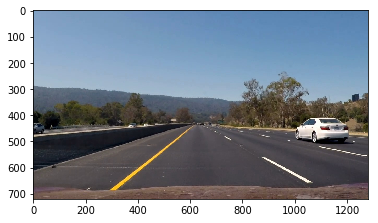

In [124]:
import matplotlib.image as mpimg

image = mpimg.imread("project_video/311.jpg")
#image = mpimg.imread("project_video/1000.jpg")
#image = top_down
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # (720, 1280)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize =3)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize =3)
abs_sobelx = np.absolute(sobelx)
abs_sobely = np.absolute(sobely)
plt.imshow(image)

In [100]:
vertices = np.array([[(200,700),(500, 400), (800, 400), (1200,700)]], dtype=np.int32)
mask = np.zeros_like(gray)

## 2.1 **sobelx**

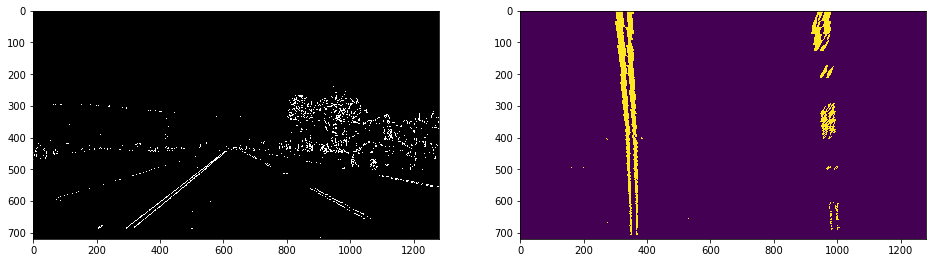

In [101]:
# Create a binary threshold to select pixels based on gradient strength
x_min,x_max = 30,90
scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
sobelx_binary = np.zeros_like(gray)
sobelx_binary[(scaled_sobelx  >= x_min) & (scaled_sobelx <= x_max)] = 1
img = sobelx_binary
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
#top_down = cv2.warpPerspective(img, M, (image.shape[1],image.shape[0]))
cv2.fillPoly(mask, vertices, 255) # 255 is for convenience of bitwise, every digit is 1
masked_gray = cv2.bitwise_and(mask,img)
top_down = cv2.warpPerspective(masked_gray, M, (image.shape[1],image.shape[0]))
plt.imshow(top_down)

## 2.2 **sobel magnitude**

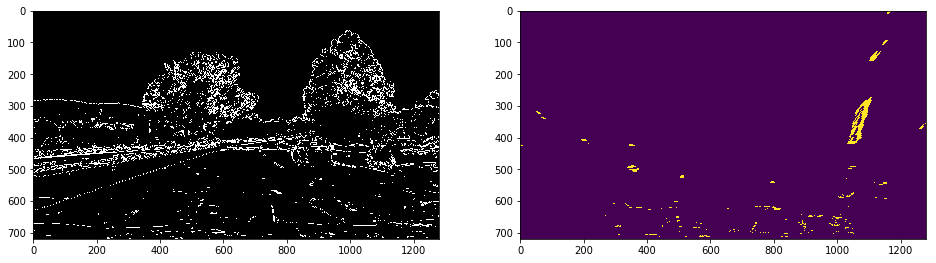

In [72]:
mag_min,mag_max = 30,80
mag = np.sqrt(sobelx**2 + sobely**2)
sacled_mag = np.uint8(255*mag/np.max(mag))
mag_binary = np.zeros_like(gray)
mag_binary[(sacled_mag >= mag_min) & (sacled_mag <= mag_max)] = 1
img = mag_binary
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
#top_down = cv2.warpPerspective(img, M, (image.shape[1],image.shape[0]))
cv2.fillPoly(mask, vertices, 255) # 255 is for convenience of bitwise, every digit is 1
masked_gray = cv2.bitwise_and(mask,img)
top_down = cv2.warpPerspective(masked_gray, M, (image.shape[1],image.shape[0]))
plt.imshow(top_down)

## 2.3 **sobel direction**

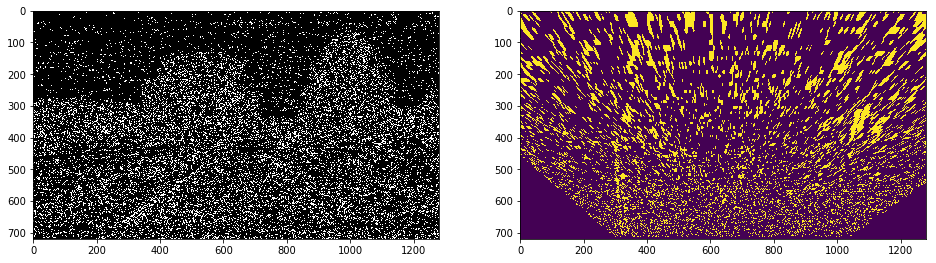

In [73]:
theta_min,theta_max = 0.8, 1.2
angle = np.arctan2(abs_sobely, abs_sobelx)
angle_binary =  np.zeros_like(gray)
angle_binary[(angle >= theta_min) & (angle <= theta_max)] = 1
img = angle_binary
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
cv2.fillPoly(mask, vertices, 255) # 255 is for convenience of bitwise, every digit is 1
masked_gray = cv2.bitwise_and(mask,img)
top_down = cv2.warpPerspective(masked_gray, M, (image.shape[1],image.shape[0]))
plt.imshow(top_down)

## 2.4 **s-channel**

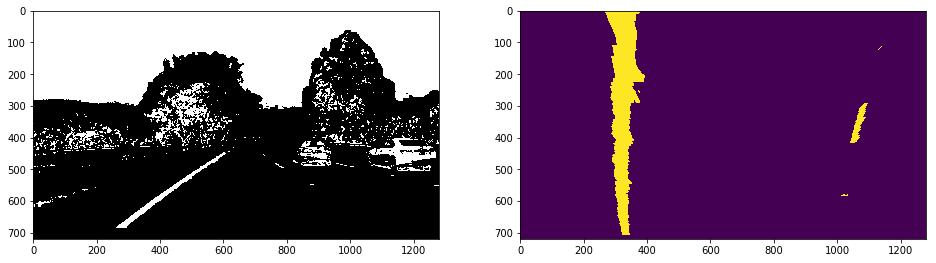

In [74]:
s_min, s_max = 100, 255
hls = cv2.cvtColor(image, cv2.COLOR_BGR2HLS)
h,l,s = cv2.split(hls)
s_binary = np.zeros_like(gray)
s_binary[(s > s_min) & (s <= s_max)] = 1
img = s_binary
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
#top_down = cv2.warpPerspective(img, M, (image.shape[1],image.shape[0]))
cv2.fillPoly(mask, vertices, 255) # 255 is for convenience of bitwise, every digit is 1
masked_gray = cv2.bitwise_and(mask,img)
top_down = cv2.warpPerspective(masked_gray, M, (image.shape[1],image.shape[0]))
plt.imshow(top_down)

## 2.5 sobelx l-channel

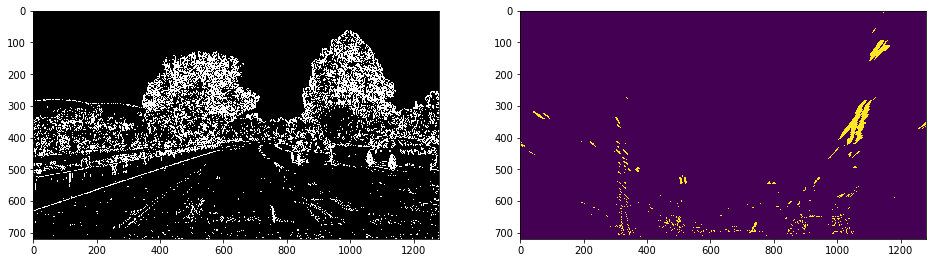

In [75]:
sl_min, sl_max = 10, 250
sobel_l = cv2.Sobel(l, cv2.CV_64F, 1, 0) 
abs_sobel_l = np.absolute(sobel_l) 
sl = np.uint8(255*abs_sobel_l/np.max(abs_sobel_l))
sl_binary = np.zeros_like(gray)
sl_binary[(sl >= sl_min) & (sl <= sl_max)] = 1
img = sl_binary
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
#top_down = cv2.warpPerspective(img, M, (image.shape[1],image.shape[0]))
#plt.imshow(top_down)
cv2.fillPoly(mask, vertices, 255) # 255 is for convenience of bitwise, every digit is 1
masked_gray = cv2.bitwise_and(mask,img)
top_down = cv2.warpPerspective(masked_gray, M, (image.shape[1],image.shape[0]))
plt.imshow(top_down)

## 2.6 red-channel

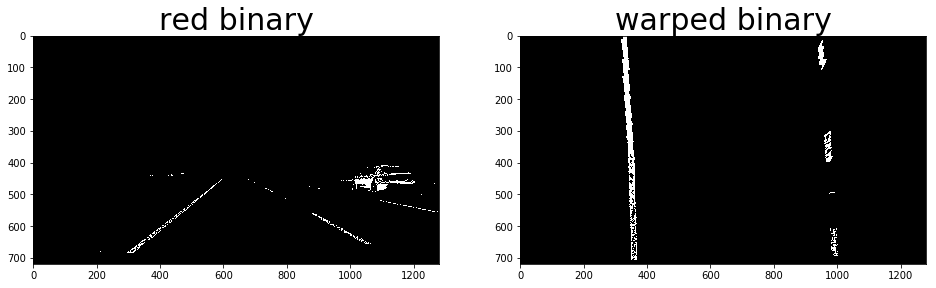

In [104]:
red_min, red_max = 210, 255
r, g, b = cv2.split(image)
red_binary = np.zeros_like(gray)
red_binary [(r> red_min)& (r < red_max)] = 1
img = red_binary
plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.title('red binary', fontsize=30)
plt.subplot(122)
cv2.fillPoly(mask, vertices, 255) # 255 is for convenience of bitwise, every digit is 1
masked_gray = cv2.bitwise_and(mask,img)
top_down = cv2.warpPerspective(masked_gray, M, (image.shape[1],image.shape[0]))
plt.imshow(top_down, cmap='gray')
plt.title('warped binary', fontsize=30)

** summary:** It seems that red-channel is already good enough

# 3. get laneline position and curvation
1. estimate initial center points 
2. use windows to pin down centers and collect lane line points for fitting
3. use fitting coefficient for next image
4. calculate the curvation and write "radius and off-center" info onto the image

## 3.1 estimate inital center points

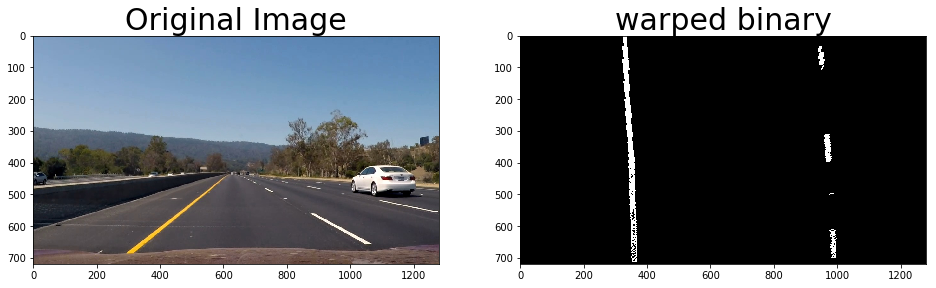

In [106]:
# reproduce warped binary from start: rgb -> undistort ->  r -> binary -> mask -> warp
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
% matplotlib inline
import numpy as np
import cv2
from sklearn.externals import joblib

image = mpimg.imread("project_video/311.jpg")   # always use matplotlib to read and display image
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # (720, 1280)

mtx, dist = joblib.load("9x6dist.p")
undist_image = cv2.undistort(image, mtx, dist, None, mtx)

red_min, red_max = 210, 255
r, g, b = cv2.split(undist_image)
red_binary = np.zeros_like(gray)
red_binary [(r> red_min)& (r < red_max)] = 1

vertices = np.array([[(200,700),(500, 400), (800, 400), (1200,700)]], dtype=np.int32)
mask = np.zeros_like(gray)
cv2.fillPoly(mask, vertices, 255) # 255 is for convenience of bitwise, every digit is 1
masked_binary = cv2.bitwise_and(mask,red_binary)

M, Minv = joblib.load("Ptransform.p") 
warped = cv2.warpPerspective(masked_binary, M, (gray.shape[1],gray.shape[0]))

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(image)
plt.title('Original Image', fontsize=30)
plt.subplot(122)
plt.imshow(warped,cmap = "gray")
plt.title('warped binary', fontsize=30)
plt.show()

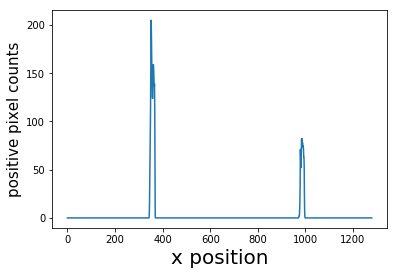

In [108]:
import numpy as np
xcount = np.sum(warped[500:], axis=0)
plt.plot(xcount)
plt.xlabel("x position", fontsize= 20)
plt.ylabel("positive pixel counts", fontsize= 15)
plt.show()

In [109]:
center1 = np.argmax(xcount[:600])
center2 = np.argmax(xcount[600:]) + 600
print("initial center x position:",center1," and ",center2)

initial center x position: 352  and  984


## 3.2 use windows to pin down centers and collect lane line points

In [110]:
nwindows = 9
window_height = np.int(warped.shape[0]/nwindows)  # 80
# Identify the x and y positions of all nonzero pixels in the image
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100 # Set the width of the windows +/- margin
minpix = 50 # Set minimum number of pixels found to recenter

In [111]:
# Create empty lists to receive left and right lane pixel indices
lane1 = []
lane2 = []
win_img = np.dstack((warped, warped, warped))*255 # prepare image to draw window

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    y_min = warped.shape[0] - (window+1)*window_height
    y_max = warped.shape[0] - window*window_height
    x1_min, x1_max = center1 - margin, center1 + margin
    x2_min, x2_max = center2 - margin, center2 + margin
    # Draw the windows 
    cv2.rectangle(win_img,(x1_min,y_min),(x1_max,y_max),(0,0,255), 6) 
    cv2.rectangle(win_img,(x2_min,y_min),(x2_max,y_max),(0,0,255), 6) 
    # Identify the nonzero pixels in x and y within the window
    select1 = ((nonzeroy >= y_min) & (nonzeroy < y_max) & (nonzerox >= x1_min) & (nonzerox < x1_max)).nonzero()[0]
    select2 = ((nonzeroy >= y_min) & (nonzeroy < y_max) & (nonzerox >= x2_min) & (nonzerox < x2_max)).nonzero()[0]
    # Append these indices to the lists
    lane1.append(select1)
    lane2.append(select2)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(select1) > minpix:
        center1 = np.int(np.mean(nonzerox[select1]))
    if len(select2) > minpix:        
        center2 = np.int(np.mean(nonzerox[select2]))

# Concatenate the arrays of indices
lane1_index = np.concatenate(lane1)
lane2_index = np.concatenate(lane2)

# Extract left and right line pixel positions
x1, y1  = nonzerox[lane1_index], nonzeroy[lane1_index] 
x2, y2  = nonzerox[lane2_index], nonzeroy[lane2_index] 

# Fit a second order polynomial to each
fit1 = np.polyfit(y1, x1, 2)
fit2 = np.polyfit(y2, x2, 2)

In [112]:
from sklearn.externals import joblib
joblib.dump((fit1,fit2), "fit.p") 

['fit.p']

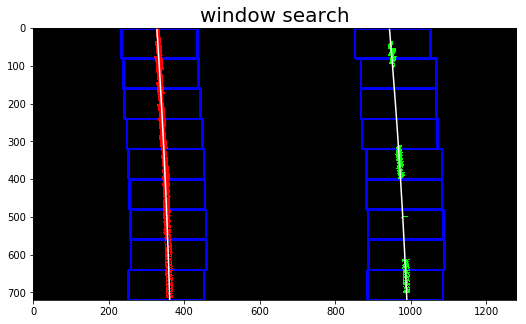

In [113]:
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
fitx1 = fit1[0]*ploty**2 + fit1[1]*ploty + fit1[2]  # generate points by fit coeff
fitx2 = fit2[0]*ploty**2 + fit2[1]*ploty + fit2[2]
win_img[y1,x1] = [255, 0 , 0]  # factual points
win_img[y2,x2] = [0,  255, 0]
plt.figure(figsize=(10,5))
plt.imshow(win_img)
plt.plot(fitx1, ploty, color='white')
plt.plot(fitx2, ploty, color='white')
plt.title("window search", fontsize = 20)
plt.show()

## 3.3 use fitting coefficient for next image

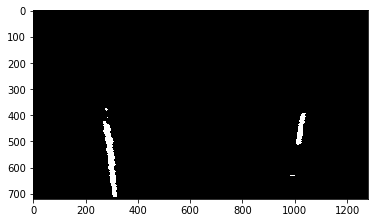

In [114]:
# preprocessing another image
image = mpimg.imread("project_video/600.jpg")   # always use matplotlib to read and display image
undist_image = cv2.undistort(image, mtx, dist, None, mtx)
r, g, b = cv2.split(undist_image)
red_binary = np.zeros_like(gray)
red_binary [(r> red_min)& (r < red_max)] = 1
mask = np.zeros_like(gray)
cv2.fillPoly(mask, vertices, 255) # 255 is for convenience of bitwise, every digit is 1
masked_binary = cv2.bitwise_and(mask,red_binary)
warped = cv2.warpPerspective(masked_binary, M, (gray.shape[1],gray.shape[0]))
plt.imshow(warped, cmap="gray")

In [115]:
fit1,fit2 = joblib.load("fit.p")
nonzero = warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
fitx1 = fit1[0]*(nonzeroy**2) + fit1[1]*nonzeroy + fit1[2] # x value on the curve for every nonzero point
fitx2 = fit2[0]*(nonzeroy**2) + fit2[1]*nonzeroy + fit2[2]
lane1_index = ((nonzerox > fitx1 - margin) & (nonzerox < fitx1 + margin)) 
lane2_index = ((nonzerox > fitx2 - margin) & (nonzerox < fitx2 + margin)) 

# extract left and right line pixel positions
x1,y1 = nonzerox[lane1_index], nonzeroy[lane1_index]
x2,y2 = nonzerox[lane2_index], nonzeroy[lane2_index]
# New fitting parameters
fit1 = np.polyfit(y1, x1, 2)
fit2 = np.polyfit(y2, x2, 2)
# Generate x and y values using new fit coeff
fitx1 = fit1[0]*ploty**2 + fit1[1]*ploty + fit1[2]  # generate points by fit coeff
fitx2 = fit2[0]*ploty**2 + fit2[1]*ploty + fit2[2]


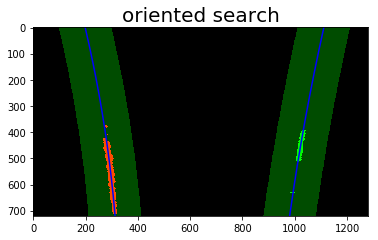

In [119]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((warped, warped, warped))*255
out_img[y1,x1] = [255, 0 , 0]  # factual points
out_img[y2,x2] = [0,  255, 0]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
window_img = np.zeros_like(out_img)
left_line_window1 = np.array([np.transpose(np.vstack([fitx1-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx1+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([fitx2-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([fitx2+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(fitx1, ploty, color='blue')
plt.plot(fitx2, ploty, color='blue')
plt.title("oriented search", fontsize = 20)
plt.show()

## 3.4 calculate the curvation and write "radius and off-center" info onto the image

In [120]:
def curvature(fit, y):
    A, B = fit[0], fit[1]
    return (1+(2*A*y+B)**2)**1.5/np.absolute(2*A)

In [121]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
# calibrated coefficients 
fit1_cal = np.polyfit(ploty*ym_per_pix, fitx1*xm_per_pix, 2)
fit2_cal = np.polyfit(ploty*ym_per_pix, fitx2*xm_per_pix, 2)
# Calculate the new radii of curvature
curv1 = curvature(fit1_cal, 30) # 720 * ym_per_pix
curv2 = curvature(fit2_cal, 30)
print("Curvatures for left lane: {0:.0f} m, right lane: {1:.0f} m".format(curv1,curv2))

Curvatures for left lane: 1573 m, right lane: 2881 m


In [122]:
off_center = -(fitx1[-1]+fitx2[-1]-1280)/2 *xm_per_pix  # assume camera sits in the center of car
print("The car is right to the center by {0:.2f} m".format(off_center))

The car is right to the center by 0.04 m


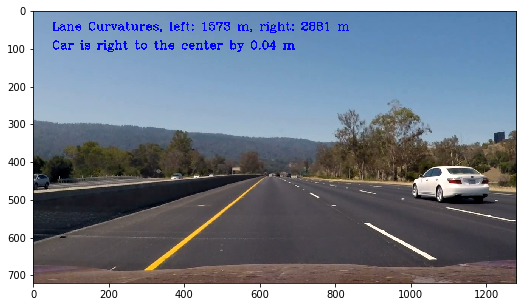

In [125]:
text1 = "Lane Curvatures, left: {0:.0f} m, right: {1:.0f} m".format(curv1,curv2)
text2 = "Car is right to the center by {0:.2f} m".format(off_center)
texted_image =cv2.putText(img=np.copy(image), text= text1, org=(50,50),
                          fontFace=3, fontScale=1, color=(0,0,255), thickness=2)
cv2.putText(img=texted_image, text= text2, org=(50,100),
                          fontFace=3, fontScale=1, color=(0,0,255), thickness=2)
plt.figure(figsize=(10,5))
plt.imshow(texted_image)
plt.show()

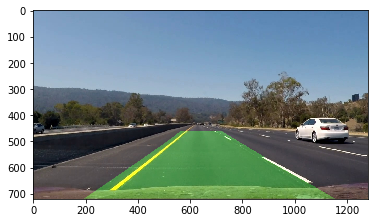

In [126]:
# Create an image to draw the lines on
color_warp = np.zeros((720,1280,3)).astype(np.uint8) 

# Recast the x and y points into usable format for cv2.fillPoly()
pts1 = np.array([np.transpose(np.vstack([fitx1, ploty]))])
pts2 = np.array([np.flipud(np.transpose(np.vstack([fitx2, ploty])))])
pts = np.hstack((pts1, pts2))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
plt.imshow(result)

# 4 build pipe line to produce video

In [92]:
from sklearn.externals import joblib
import cv2
import numpy as np
M, Minv = joblib.load("Ptransform.p")
fit1,fit2 = joblib.load("fit.p")
red_min, red_max = 210, 255
vertices = np.array([[(200,700),(500, 400), (800, 400), (1200,700)]], dtype=np.int32)

margin = 100
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
def curvature(fit, y):
    A, B = fit[0], fit[1]
    return (1+(2*A*y+B)**2)**1.5/np.absolute(2*A)
def pipeline(image):
    global fit1,fit2

    # detailed explanation see section 3.3
    r = image[:,:,0]
    red_binary = np.zeros_like(gray)
    red_binary [(r> red_min)& (r < red_max)] = 1
    mask = np.zeros_like(gray)
    cv2.fillPoly(mask, vertices, 255)
    masked_binary = cv2.bitwise_and(mask,red_binary)
    warped = cv2.warpPerspective(masked_binary, M, (gray.shape[1],gray.shape[0]))

    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    fitx1 = fit1[0]*(nonzeroy**2) + fit1[1]*nonzeroy + fit1[2]
    fitx2 = fit2[0]*(nonzeroy**2) + fit2[1]*nonzeroy + fit2[2]
    lane1_index = ((nonzerox > fitx1 - margin) & (nonzerox < fitx1 + margin))
    lane2_index = ((nonzerox > fitx2 - margin) & (nonzerox < fitx2 + margin))
    x1,y1 = nonzerox[lane1_index], nonzeroy[lane1_index]
    x2,y2 = nonzerox[lane2_index], nonzeroy[lane2_index]
    fit1 = np.polyfit(y1, x1, 2)
    fit2 = np.polyfit(y2, x2, 2)
    # calibrated coefficients
    fitx1 = fit1[0]*ploty**2 + fit1[1]*ploty + fit1[2]  
    fitx2 = fit2[0]*ploty**2 + fit2[1]*ploty + fit2[2]
    fit1_cal = np.polyfit(ploty*ym_per_pix, fitx1*xm_per_pix, 2)
    fit2_cal = np.polyfit(ploty*ym_per_pix, fitx2*xm_per_pix, 2)
    curv1 = curvature(fit1_cal, 30)
    curv2 = curvature(fit2_cal, 30)
    off_center = (fitx1[-1]+fitx2[-1]-1280)/2 *xm_per_pix
    text1 = "Lane Curvatures, left: {0:.0f} m, right: {1:.0f} m".format(curv1,curv2)
    text2 = "Car is right to the center by {0:.2f} m".format(off_center)
    texted_image = np.copy(image)
    cv2.putText(img=texted_image, text= text1, org=(50,50),
                          fontFace=3, fontScale=1, color=(0,0,255), thickness=2)
    cv2.putText(img=texted_image, text= text2, org=(50,100),
                          fontFace=3, fontScale=1, color=(0,0,255), thickness=2)

    color_warp = np.zeros((720,1280,3)).astype(np.uint8)
    pts1 = np.array([np.transpose(np.vstack([fitx1, ploty]))])
    pts2 = np.array([np.flipud(np.transpose(np.vstack([fitx2, ploty])))])
    pts = np.hstack((pts1, pts2))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(texted_image, 1, newwarp, 0.3, 0)

    return result

In [93]:
from moviepy.editor import VideoFileClip
output = 'project_output.mp4'
challenge_clip = VideoFileClip('project_video.mp4').fl_image(pipeline)
%time challenge_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output.mp4
[MoviePy] Writing video project_output.mp4


100%|█████████▉| 1260/1261 [01:10<00:00, 16.94it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output.mp4 

CPU times: user 1min 54s, sys: 17.1 s, total: 2min 11s
Wall time: 1min 11s


In [94]:
from IPython.display import HTML
HTML("""<video width="500"  controls><source src="{0}"></video>
""".format(output))

Note: In the first attempt, the pipeline failed at around 20s when the road brighteness suddenly increases. Then I increase the red threshold from 150 to 210 and it works!.  I also have s-channel in mind if this doesn't work.

## Optional challenge

In [215]:
from moviepy.editor import VideoFileClip
output = 'challenge_output.mp4'
challenge_clip = VideoFileClip('harder_challenge_video.mp4').fl_image(pipeline)
%time challenge_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4


 50%|████▉     | 598/1200 [00:37<00:29, 20.20it/s]

TypeError: expected non-empty vector for x

 50%|████▉     | 598/1200 [00:50<00:50, 11.96it/s]